# Random Forests

Random Forest is a bagging technique that trains multiple decision trees with minor modification in the split criterion.

![Random Forest](./Random_Forest_1.jpeg)

In case of a decision tree, we train a single decision tree, whereas in Random Forest, we train multiple decision trees on different training sets obtained through bootstrap aggregation (bagging).

## The Algorithm

**Input:**

Training data $D$ with shape $(n,m)$, where $n$ is the no. of examples and $m$ is the no. of features.

**Steps:**

1. Sample $q$ datasets each of shape $(n,m)$, say $D_1, D_2. \dots D_q$ with replacement from $D$.
2. In each dataset $D_j$, select $u$ out of $m$, where $u \le m$ features before each split and train a full decision tree $h_j(\vec{x})$.
3. The final predictor is
    - For regression, an average output from $q$ regressors is assigned to the new example:
    $$h(\vec{x}) = \frac{1}{q}\sum_{j=1}^{q} h_j(\vec{x}) $$
    - For classification, a majority voting is taken and the class label with maximum no. of votes is assigned to the new example.

## Implementation

In order to keep the implementation focused to the main components of random forest, we make use of `DecisionTreeClassifier` from `sklearn.tree` module for the decision tree component.

In [2]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.tree import DecisionTreeClassifier

We will build the code component-wise and finally combine them into `RondomForest` class.

### Bagging

We define a function for bagging - creating $q$ bootstrap samples $D_1, D_2, \dots D_q$ from the original dataset $D$:
- The key step is `np.random.choice` with `size=n_samples` and `replace=True` which ensures that the bootstrap sample has the same number of samples as the original dataset and it is obtained by sampling with replacement.

In [23]:
def bag(X,y):
    # Counts the no. of rows in the feature matrix
    n_samples = X.shape[0]

    # Generates a random sample from the given input.
    indices = np.random.choice(
        n_samples,
        size=n_samples,
        replace=True
    )
    # Note that the second argument size has been set to the size of the original sample dataset and replacement has been set to True
    # This will allow repitition of indices

    return X[indices],y[indices]

### Majority Voting

Code up `most_common_label` function for obtaining majority vote for class labels.

In [3]:
def most_common_label(y):
    counter = Counter(y)
    most_common = counter.most_common(1)[0][0]
    return most_common

## Random Forest Class

We create `RandomForest` class with the following default parameters:
- no. of tree = 10
- minimum no. of samples = 2
- maximum depth = 100

The `max_features` is a configurable parameter that can be set by the user.

In [5]:
class RandomForest:
    def __init__(self, n_trees=10, min_samples_split=2, max_depth=100, max_features=None):
        # hyperparameter for fixing no. of trees to be generated
        self.n_trees=n_trees
        # min no. of samples required for split
        self.min_samples_split=min_samples_split
        # max depth of decison tree
        self.max_depth=max_depth
        # max no. of features to be considered
        self.max_features=max_features
        self.trees = []

## Training Random Forest

We implement `fit` method.
- Initialize an empty list of decision tree classifiers.
- In the for loop, we train each decision tree with parameters set from the andom forest on a bootstrapped sample obtained via the `bag` function.

In [6]:
    def fit(self, X,y):
        # Empty array of tree which gets filled in during operation
        self.trees = []
        for _ in range(self.n_trees):
            # We will now make RF class inherit features from sklearn.tree.DecisionTreeClassifier
            tree = DecisionTreeClassifier(
                min_samples_split=self.min_samples_split,
                max_depth=self.max_depth,
                max_features=self.max_features
            )
            X_sample, y_sample = bag(X,y)
            tree.fit(X_sample,y_sample)
            # We append each of these trees
            self.trees.append(tree)

## Inference

Let's implement the `predict` function.

Here, we need to note that each of the trees will be give predictions for all the individual rows of the input data.

For example, if we have random forest with $3$ trees and $2$ classes `0` and `1`, let's assume the prediction for $5$ samples is as follows:
- Tree 1 gives `11001`
- Tree 2 gives `00111`
- Tree 3 gives `10101`

We need to aggregate the output for the respective samples and take an average/majority vote. For this, we will use `np.swapaxes`.

In [26]:
    def predict(self, X):
        # Converting the list of predictions from the models into a numpy array
        tree_predict = np.array([tree.predict(X) for tree in self.trees])
        # Each tree will give out its own predictions
        tree_predict = np.swapaxes(tree_predict, 0, 1)
        # After swapping the axes, each row in tree_predict, contains the predictions of a partical input w.r.t. all the trees
        y_pred = [most_common_label(tree_pred) for tree_pred in tree_predict]
        return np.array(y_pred)

## Combined Cleaned Up Code

Combining different components for creating the class.

In [28]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.tree import DecisionTreeClassifier

def bag(X,y):
    # Counts the no. of rows in the feature matrix
    n_samples = X.shape[0]

    # Generates a random sample from the given input.
    indices = np.random.choice(
        n_samples,
        size=n_samples,
        replace=True
    )
    # Note that the second argument size has been set to the size of the original sample dataset and replacement has been set to True
    # This will allow repitition of indices

    return X[indices],y[indices]

def most_common_label(y):
    counter = Counter(y)
    most_common = counter.most_common(1)[0][0]
    return most_common

class RandomForest:
    def __init__(self, n_trees=10, min_samples_split=2, max_depth=100, max_features=None):
        # hyperparameter for fixing no. of trees to be generated
        self.n_trees=n_trees
        # min no. of samples required for split
        self.min_samples_split=min_samples_split
        # max depth of decison tree
        self.max_depth=max_depth
        # max no. of features to be considered
        self.max_features=max_features
        self.trees = []

    def fit(self, X,y):
        # Empty array of tree which gets filled in during operation
        self.trees = []
        for _ in range(self.n_trees):
            # We will now make RF class inherit features from sklearn.tree.DecisionTreeClassifier
            tree = DecisionTreeClassifier(
                min_samples_split=self.min_samples_split,
                max_depth=self.max_depth,
                max_features=self.max_features
            )
            X_sample, y_sample = bag(X,y)
            tree.fit(X_sample,y_sample)
            # We append each of these trees
            self.trees.append(tree)

    def predict(self, X):
        # Converting the list of predictions from the models into a numpy array
        tree_predict = np.array([tree.predict(X) for tree in self.trees])
        # Each tree will give out its own predictions
        tree_predict = np.swapaxes(tree_predict, 0, 1)
        # After swapping the axes, each row in tree_predict, contains the predictions of a partical input w.r.t. all the trees
        y_pred = [most_common_label(tree_pred) for tree_pred in tree_predict]
        return np.array(y_pred)

Let's demonstrate our implementation of Random Forest on a real world dataset.

In [29]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true==y_pred)/len(y_true)
    return accuracy

X,y = load_breast_cancer(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=69)

clf = RandomForest(n_trees=10, max_depth=10, max_features='sqrt')
clf.fit(X_train, y_train)

y_test_hat = clf.predict(X_test)
acc = accuracy(y_test, y_test_hat)

print("Accuracy: ", acc)

Accuracy:  0.9649122807017544


Let's look at other evaluation metrics.

In [30]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, y_test_hat)
print(matrix)

[[51  3]
 [ 1 59]]


In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_hat))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96        54
           1       0.95      0.98      0.97        60

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



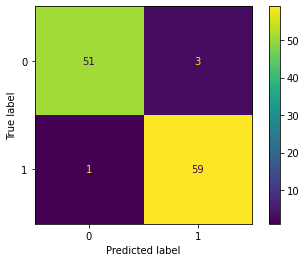

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(matrix)
disp.plot()
plt.show()
